<a href="https://colab.research.google.com/github/pedrohortencio/kaggle-competitions/blob/main/TMDB/TMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Competition's Page](https://www.kaggle.com/c/tmdb-box-office-prediction/overview)

# Importing Packages, Libraries and Downloading Data

In [63]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!kaggle competitions download -c tmdb-box-office-prediction

kaggle.json
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [64]:
import numpy as np                  
import pandas as pd
import ast
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_theme(style='white', palette='muted')

from sklearn.model_selection import train_test_split
import xgboost as xg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

In [65]:
sample = pd.read_csv("/content/sample_submission.csv")
df_train = pd.read_csv("/content/train.csv.zip", compression='zip')
df_test = pd.read_csv("/content/test.csv.zip", compression='zip')

# Inspecting Data

In [66]:
print(df_train.shape)
df_train.head(2)

(3000, 23)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


In [67]:
print(df_test.shape)
df_test.head(2)

(4398, 22)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."


In [68]:
df_train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [69]:
df_test.isna().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

# Treating Columns with Dicts

In [70]:
columns_with_dicts = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']
def dict_columns(df):
    for column in columns_with_dicts:

        df[column] = df[column].apply(lambda row: {}
                                      if pd.isna(row)   # empty dict if NaN, the value if not
                                      else ast.literal_eval(row))  # (evaluated to see if it is a Python valid data structure)
                                                                                               

    return df

df_train = dict_columns(df_train)
df_test = dict_columns(df_test)

In [71]:
df_train.isna().sum()

id                          0
belongs_to_collection       0
budget                      0
genres                      0
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies        0
production_countries        0
release_date                0
runtime                     2
spoken_languages            0
status                      0
tagline                   597
title                       0
Keywords                    0
cast                        0
crew                        0
revenue                     0
dtype: int64

# "belongs_to_collection" Column

In [72]:
def extract_collection_name(x):
    if x != {}:
        return x[0]['name']
    else:
        return 0

def is_collection(x):
    if x != {}:
        return 1
    else:
        return 0

df_train['collection_name'] = df_train['belongs_to_collection'].apply(extract_collection_name)
df_train['part_of_collection'] = df_train['belongs_to_collection'].apply(is_collection)

df_test['collection_name'] = df_test['belongs_to_collection'].apply(extract_collection_name)
df_test['part_of_collection'] = df_test['belongs_to_collection'].apply(is_collection)

# Genres Column

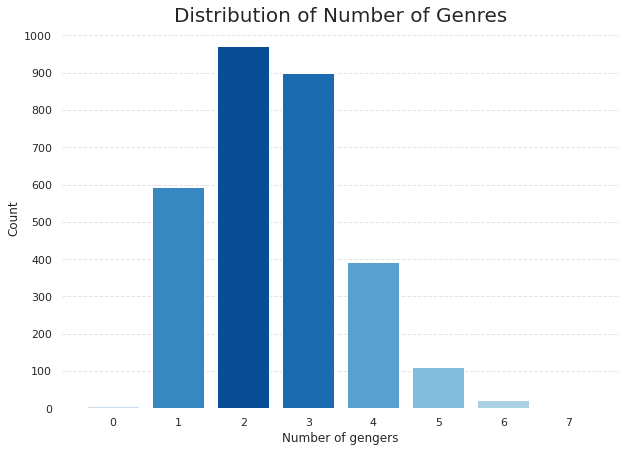

In [73]:
number_of_genres = df_train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(10, 7))
plt.bar(x=number_of_genres.index, height=number_of_genres.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of gengers")
plt.title("Distribution of Number of Genres", size=20)
plt.yticks([i for i in range(0, 1100, 100)])
plt.box(False)

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

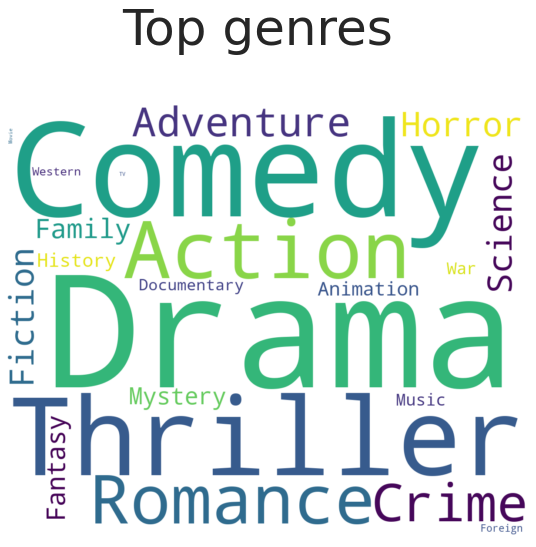

In [74]:
list_of_genres = list(df_train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
text = ' '.join([i for j in list_of_genres for i in j])

plt.figure(figsize = (12, 8))

wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)

plt.imshow(wordcloud,interpolation="bilinear")

plt.suptitle('Top genres', size=50, y=1.05)
plt.axis("off")

plt.show();

In [75]:
genres_occurances = Counter([i for j in list_of_genres for i in j]).most_common()
genres_occurances

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

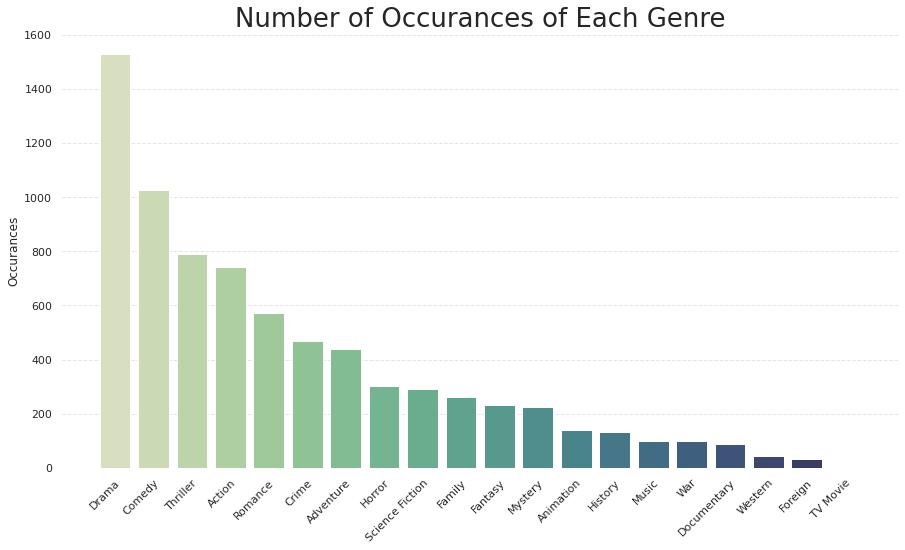

In [76]:
genres_occurances = Counter([i for j in list_of_genres for i in j]).most_common()

genres_occurances_names = [x[0] for x in genres_occurances]
genres_occurances_values = [x[1] for x in genres_occurances]

fig = plt.figure(figsize=(15, 8))
plt.bar(x=genres_occurances_names, height=genres_occurances_values, color=sns.color_palette("ch:start=.5,rot=-.75", n_colors=22))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls='--')
plt.title("Number of Occurances of Each Genre", size=26)
plt.ylabel("Occurances")

plt.show();

In [77]:
df_train['num_genres'] = df_train['genres'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_genres'] = df_test['genres'].apply(lambda x: len(x) if x != {} else 0)

# "production_companies" Column

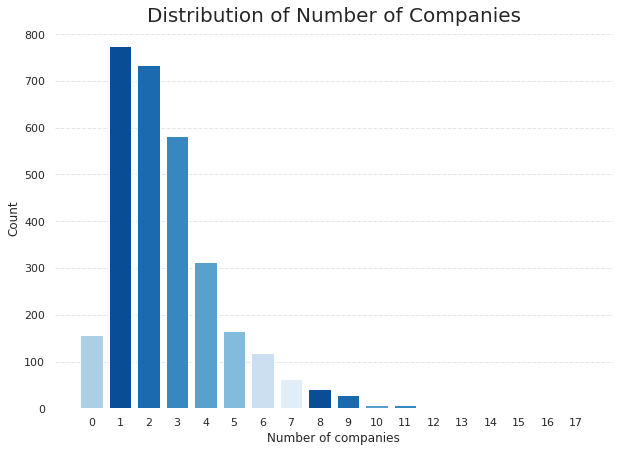

In [78]:
number_of_companies = df_train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(10, 7))
plt.bar(x=number_of_companies.index, height=number_of_companies.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of companies")
plt.title("Distribution of Number of Companies", size=20)
plt.box(False)
plt.xticks([i for i in range(0, 18)])

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

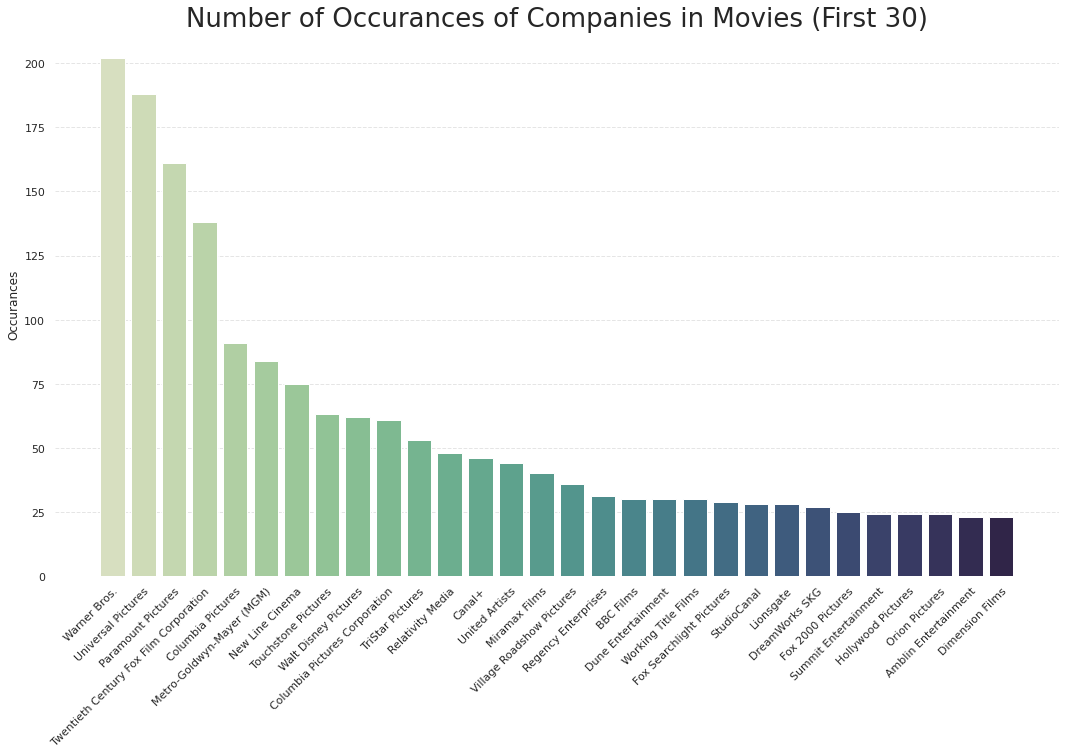

In [79]:
list_of_companies = list(df_train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count_companies = Counter([i for j in list_of_companies for i in j]).most_common(30)

companies_names = []
occurance_values = []

for companie in count_companies:
    name, value = companie
    
    companies_names.append(name)
    occurance_values.append(value)

fig = plt.figure(figsize=(18, 10))
plt.bar(x=companies_names, height=occurance_values, color=sns.color_palette("ch:start=.5,rot=-.75", n_colors=31))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls='--')
plt.title("Number of Occurances of Companies in Movies (First 30)", size=26)
plt.ylabel("Occurances")

plt.show();

In [80]:
df_train['num_companies'] = df_train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_companies'] = df_test['production_companies'].apply(lambda x: len(x) if x != {} else 0)

# "production_countries" Column

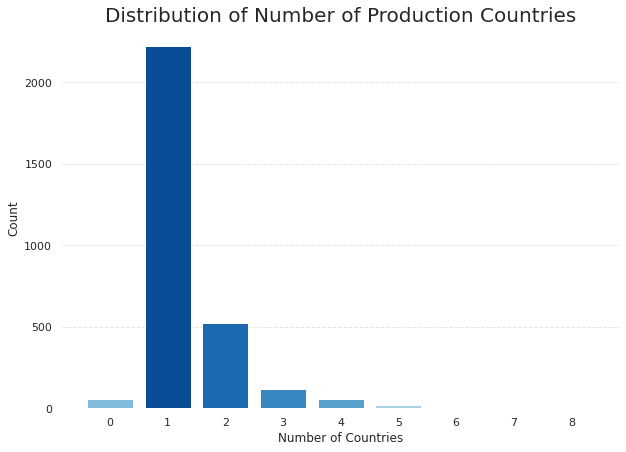

In [81]:
production_countries_number = df_train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(10, 7))
plt.bar(x=production_countries_number.index, height=production_countries_number.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of Countries")
plt.title("Distribution of Number of Production Countries", size=20)
plt.box(False)
plt.xticks([i for i in range(0, 9)])

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

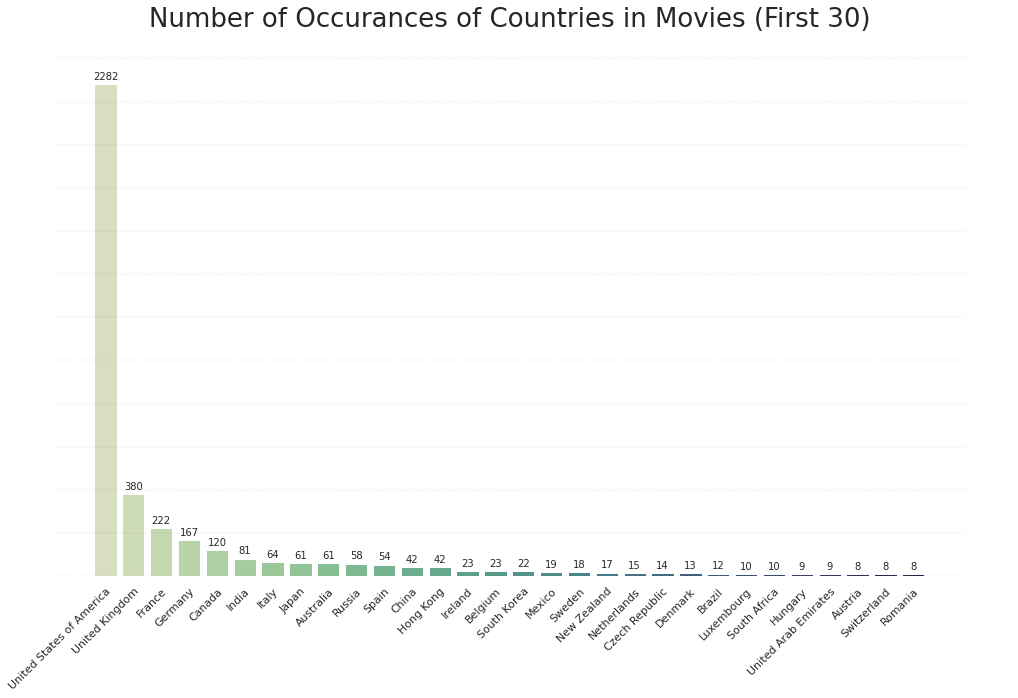

In [82]:
list_of_countries = list(df_train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count_countries = Counter([i for j in list_of_countries for i in j]).most_common(30)

countries_names = [x[0] for x in count_countries]
occurance_values = [x[1] for x in count_countries]

fig = plt.figure(figsize=(18, 10))

ax = plt.gca()

rects1 = ax.bar(x=countries_names, height=occurance_values, color=sns.color_palette("ch:start=.5,rot=-.75", n_colors=31))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    fontsize = 10,
                    ha='center', va='bottom')

autolabel(rects1)

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.hlines([i for i in range(0, 2600, 200)], *ax.get_xlim(), color='k', linestyles='--', lw=0.3, alpha=0.2)
plt.yticks([])
plt.title("Number of Occurances of Countries in Movies (First 30)", size=26)


plt.show();

In [83]:
df_train['num_countries'] = df_train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_countries'] = df_test['production_countries'].apply(lambda x: len(x) if x != {} else 0)

# "spoken_languages" Column

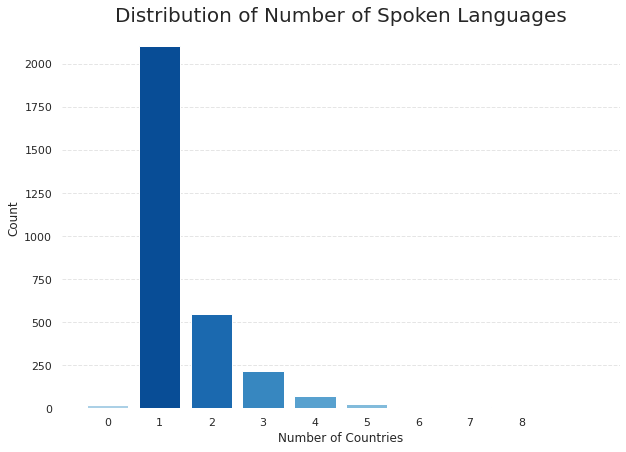

In [84]:
spoken_languages_number = df_train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(10, 7))
plt.bar(x=spoken_languages_number.index, height=spoken_languages_number.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of Countries")
plt.title("Distribution of Number of Spoken Languages", size=20)
plt.box(False)
plt.xticks([i for i in range(0, 9)])

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

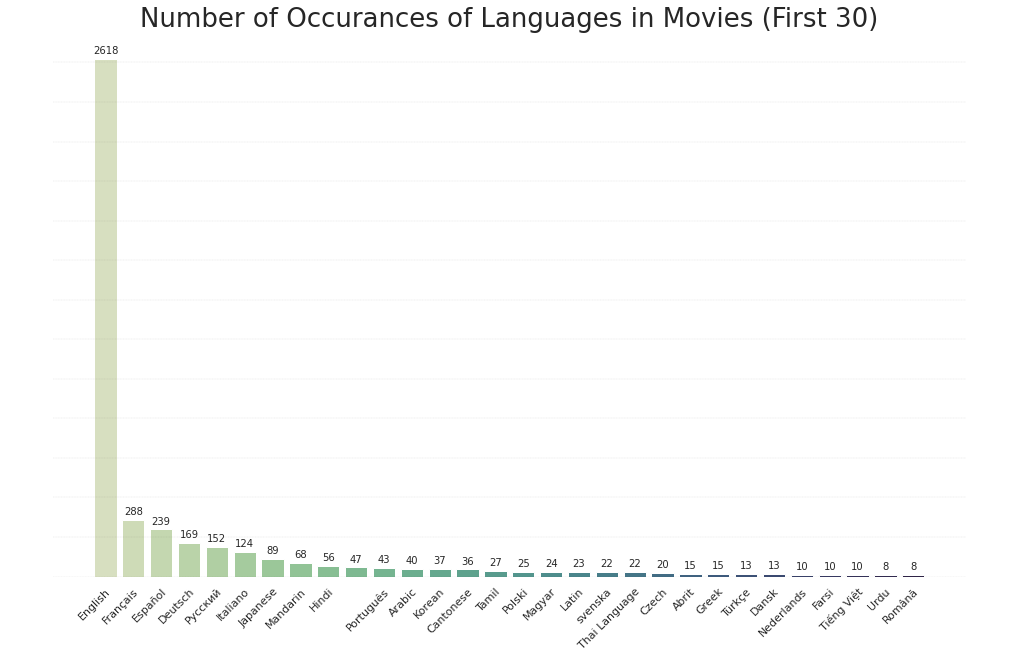

In [85]:
list_of_languages  = list(df_train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count_languages = Counter([i for j in list_of_languages for i in j]).most_common(30)

language_names = [x[0] for x in count_languages]
occurance_values = [x[1] for x in count_languages]

language_names = ['English','Français','Español','Deutsch','Pусский',
                  'Italiano','Japanese','Mandarin','Hindi','',
                  'Português','Arabic','Korean','Cantonese','Tamil',
                  'Polski','Magyar','Latin','svenska','Thai Language','Czech',
                  'Abrit','Greek','Türkçe','Dansk','Nederlands',
                  'Farsi','Tiếng Việt','Urdu','Română']

fig = plt.figure(figsize=(18, 10))


ax = plt.gca()

rects1 = ax.bar(x=language_names, height=occurance_values, color=sns.color_palette("ch:start=.5,rot=-.75", n_colors=31))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    fontsize = 10,
                    ha='center', va='bottom')

autolabel(rects1)
plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.yticks([])
plt.hlines([i for i in range(0, 2800, 200)], *ax.get_xlim(), color='k', linestyles='--', lw=0.3, alpha=0.2)

plt.title("Number of Occurances of Languages in Movies (First 30)", size=26)

plt.show();

In [86]:
df_train['num_languages'] = df_train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_languages'] = df_test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)

# Keywords Column

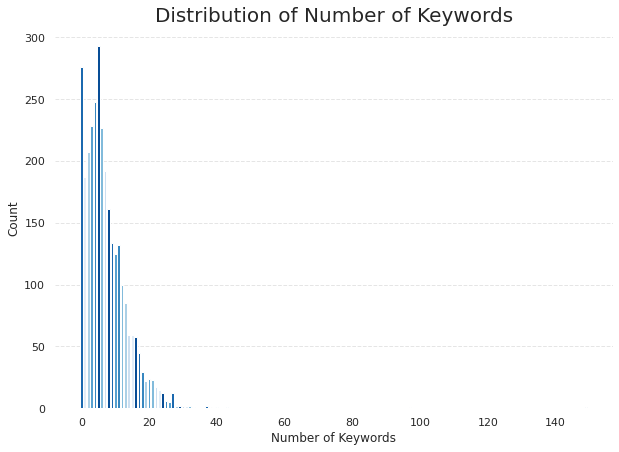

In [87]:
keywords_number = df_train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(10, 7))
plt.bar(x=keywords_number.index, height=keywords_number.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of Keywords")
plt.title("Distribution of Number of Keywords", size=20)
plt.box(False)

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

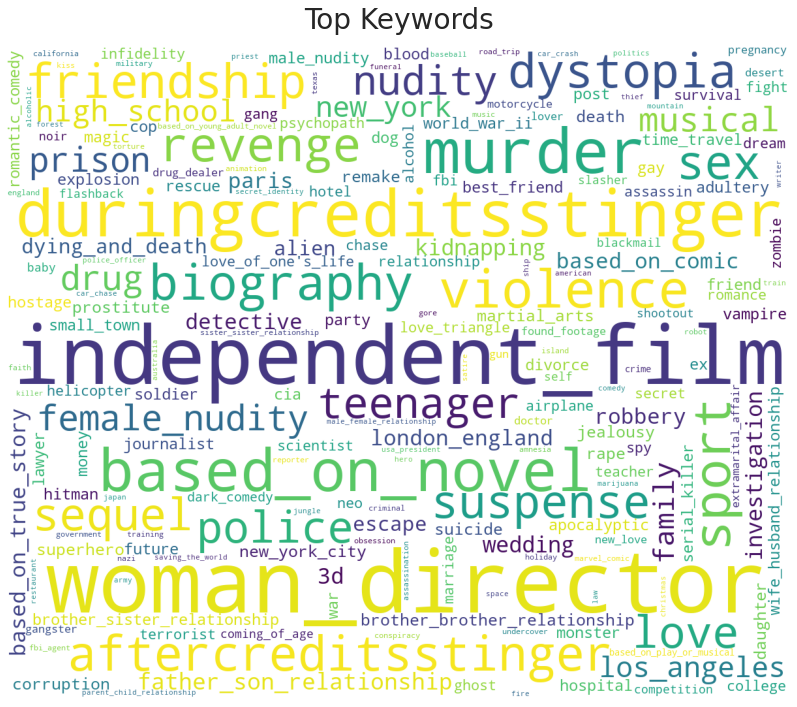

In [88]:
list_of_keywords = list(df_train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)

plt.imshow(wordcloud)
plt.title('Top Keywords', size = 28, y = 1.02)
plt.axis("off")
plt.show()

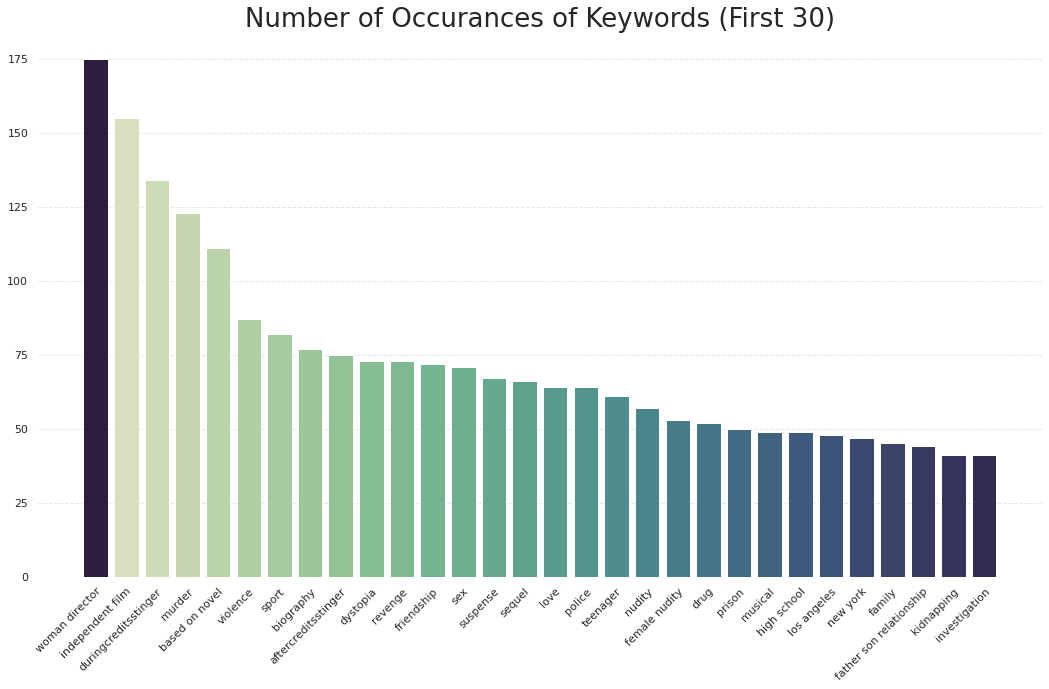

In [89]:
list_of_keywords = list(df_train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count_keywords = Counter([i for j in list_of_keywords for i in j]).most_common(30)

keywords_names = [x[0] for x in count_keywords]
occurance_values = [x[1] for x in count_keywords]

for keyword in count_keywords:
    name, value = keyword
    
    keywords_names.append(name)
    occurance_values.append(value)

fig = plt.figure(figsize=(18, 10))

plt.bar(x=keywords_names, height=occurance_values, color=sns.color_palette("ch:start=.5,rot=-.75", n_colors=31))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls="--")

plt.title("Number of Occurances of Keywords (First 30)", size=26)


plt.show();

In [90]:
df_train['num_Keywords'] = df_train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_Keywords'] = df_test['Keywords'].apply(lambda x: len(x) if x != {} else 0)

# Cast Column

### Actors and Actress

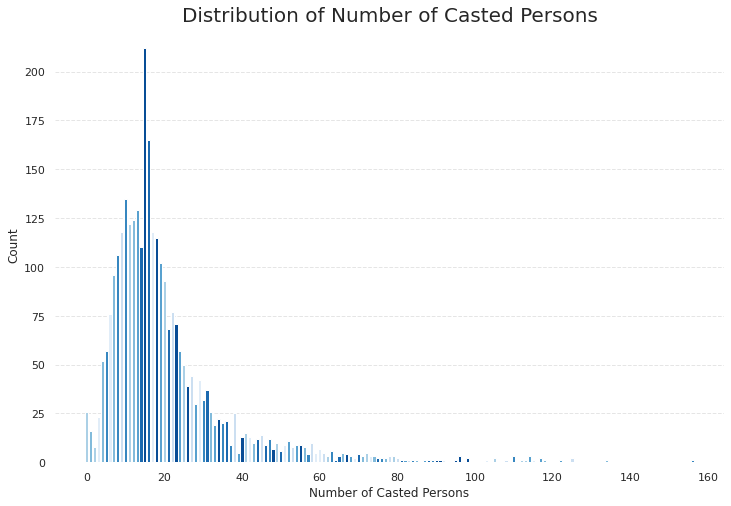

In [91]:
casted_number = df_train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(12, 8))
plt.bar(x=casted_number.index, height=casted_number.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of Casted Persons")
plt.title("Distribution of Number of Casted Persons", size=20)
plt.box(False)

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

In [92]:
df_train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(80)

15     212
16     165
10     135
13     129
12     124
      ... 
114      3
71       3
62       3
125      2
69       2
Name: cast, Length: 80, dtype: int64

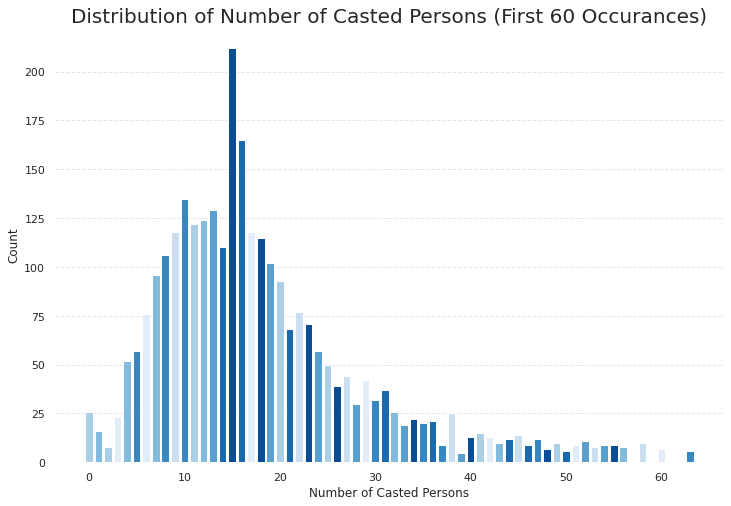

In [93]:
casted_number = df_train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(60)

fig = plt.figure(figsize=(12, 8))
plt.bar(x=casted_number.index, height=casted_number.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of Casted Persons")
plt.title("Distribution of Number of Casted Persons (First 60 Occurances)", size=20)
plt.box(False)

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

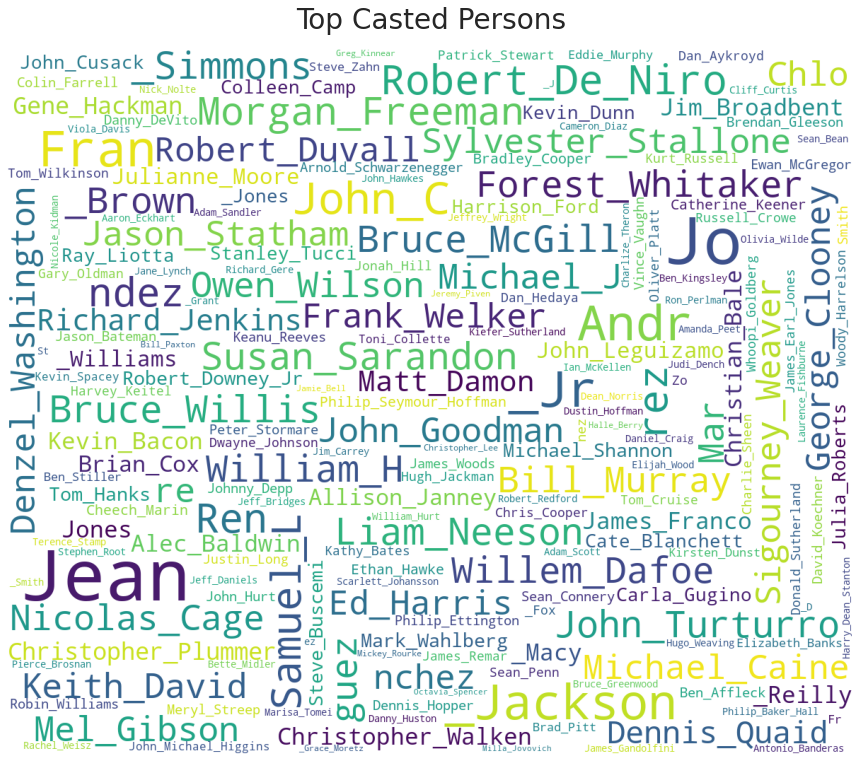

In [94]:
list_of_cast_names = list(df_train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

plt.figure(figsize = (18, 13))

text = ' '.join(['_'.join(i.split(' ')) for j in list_of_cast_names for i in j])
wordcloud = WordCloud(max_font_size=100, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)

plt.imshow(wordcloud)
plt.title('Top Casted Persons', size = 28, y = 1.02)
plt.axis("off")
plt.show()

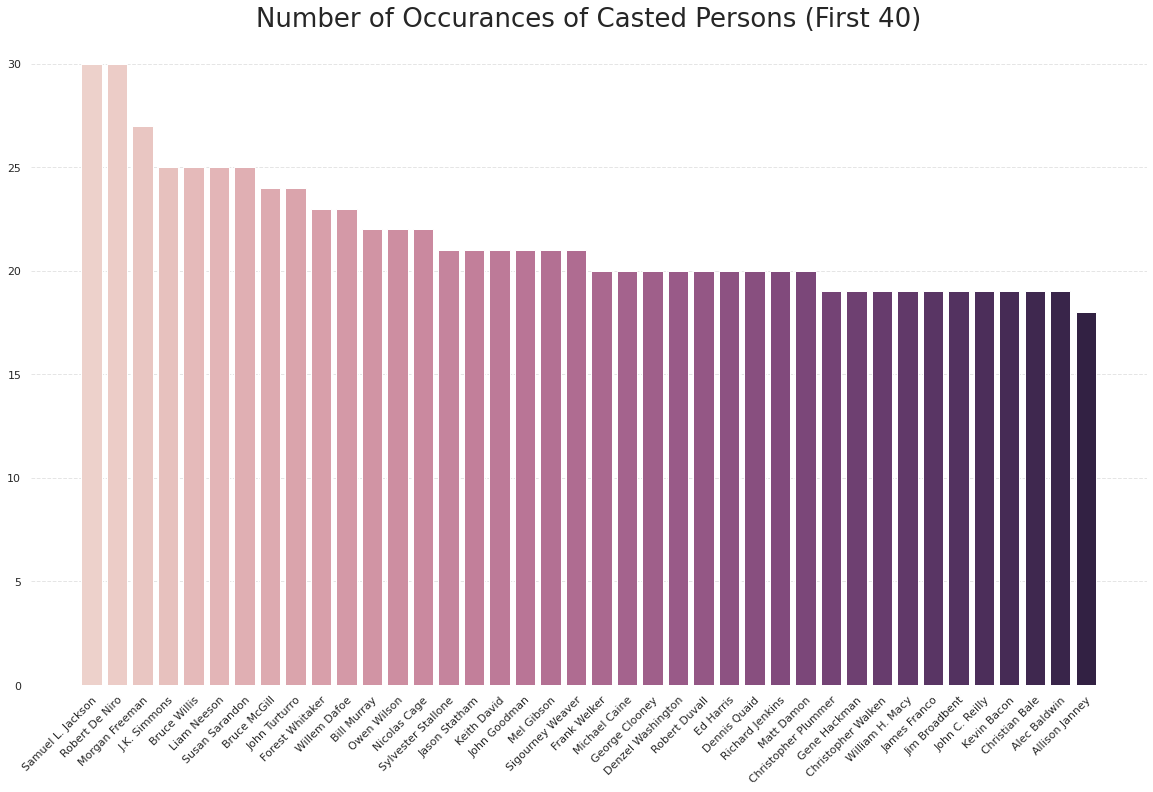

In [95]:
list_of_cast_names = list(df_train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count_casted = Counter([i for j in list_of_cast_names for i in j]).most_common(40)

casted_names = [x[0] for x in count_casted]
occurance_values = [x[1] for x in count_casted]

fig = plt.figure(figsize=(20, 12))

plt.bar(x=casted_names, height=occurance_values, color=sns.cubehelix_palette(n_colors=41))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls="--")

plt.title("Number of Occurances of Casted Persons (First 40)", size=26)

plt.show();

### Gender

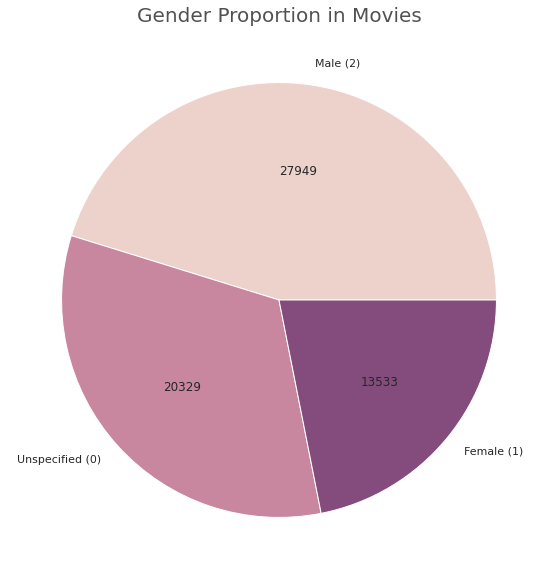

In [96]:
list_of_cast_genders = list(df_train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
lst_genders = Counter([i for j in list_of_cast_genders for i in j]).most_common()

idx = ["Male (2)", "Unspecified (0)", "Female (1)"]
vls = np.array([x[1] for x in lst_genders])


def absolute_value(val):
    a  = np.round(val/100.*vls.sum(), 0)
    return int(a)

fig = plt.figure(figsize=(10, 10))

plt.pie(vls, labels=idx, colors=sns.cubehelix_palette(n_colors=4),
        autopct=absolute_value)

plt.title('Gender Proportion in Movies',
          size=20, alpha=0.8)

plt.show();

In [97]:
df_train.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,part_of_collection,num_genres,num_companies,num_countries,num_languages,num_Keywords
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1,1,3,1,1,4
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1,4,1,1,1,4


In [98]:
df_test.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,collection_name,part_of_collection,num_genres,num_companies,num_countries,num_languages,num_Keywords
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,{},"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",Pokémon Collection,1,4,0,2,2,2
1,3002,{},88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",0,0,2,1,1,1,8


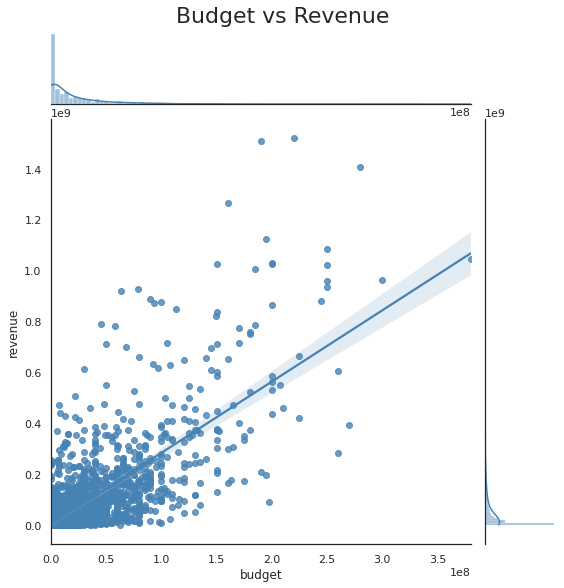

In [ ]:
sns.jointplot(x="budget", y="revenue", kind='reg',data=df_train, color='steelblue', height=8)
plt.suptitle("Budget vs Revenue", size=22, y=1.02)
plt.show();

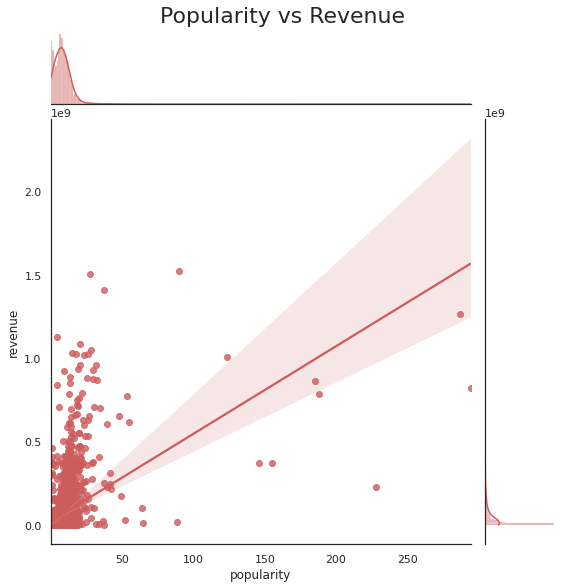

In [ ]:
sns.jointplot(x="popularity", y="revenue", kind='reg',data=df_train, color='indianred', height=8)
plt.suptitle("Popularity vs Revenue", size=22, y=1.02)
plt.show();

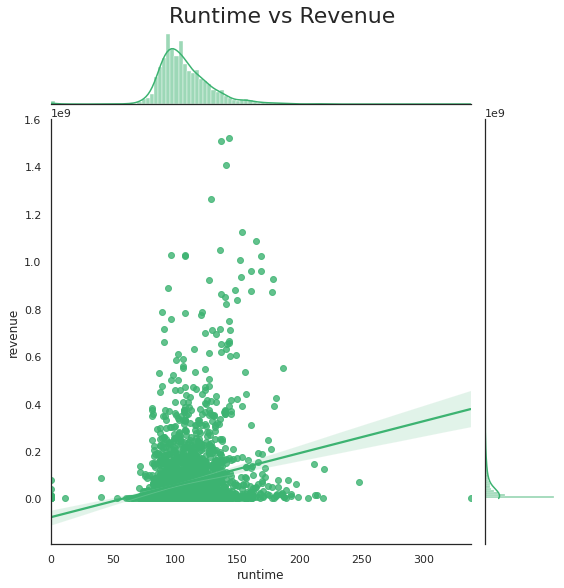

In [ ]:
sns.jointplot(x="runtime", y="revenue", kind='reg',data=df_train, color='mediumseagreen', height=8)
plt.suptitle("Runtime vs Revenue", size=22, y=1.02)
plt.show();

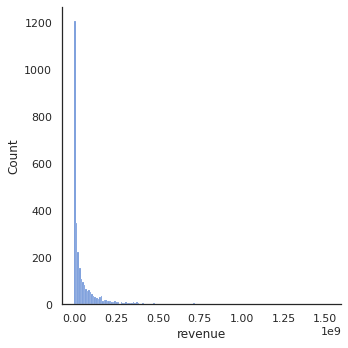

In [ ]:
sns.displot(df_train.revenue);